In [2]:
%matplotlib inline
import urllib
import pickle
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt


In [74]:
SYNSET_FILE='synset_words.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
labels=open(SYNSET_FILE).read().split('\n')

In [79]:
class GradCam:
    def __init__(self, model):
        self.model = model.eval()
        self.feature = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def __call__(self, x):
        image_size = (x.size(-1), x.size(-2))
        feature_maps = []
        
        for i in range(x.size(0)):
            img = x[i].data.cpu().numpy()
            img = img - np.min(img)
            if np.max(img) != 0:
                img = img / np.max(img)

            feature = x[i].unsqueeze(0)
            
            for name, module in self.model.named_children():
                if name == 'classifier':
                    feature = feature.view(feature.size(0), -1)
                feature = module(feature)
                if name == 'features':
                    feature.register_hook(self.save_gradient)
                    self.feature = feature
                     
            classes = F.sigmoid(feature)
            one_hot, _ = classes.max(dim=-1)
            self.model.zero_grad()
            #最終conv層への逆伝搬(勾配)を計算
            one_hot.backward()
            #最終conv層のチャンネル毎に平均勾配を計算して、各チャンネルの重要度とする
            weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
            #最終conv層の順伝搬の出力にチャンネル毎の重みをかけて、足し合わせて、ReLUを通す 
            mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
            mask = cv2.resize(mask.data.cpu().numpy(), image_size)
            mask = mask - np.min(mask)
            
            if np.max(mask) != 0:
                mask = mask / np.max(mask)
                
            feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
            
            cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
            cam = cam - np.min(cam)
            
            if np.max(cam) != 0:
                cam = cam / np.max(cam)
                
            feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))
            
        feature_maps = torch.stack(feature_maps)
        
        return feature_maps

image size:  (1024, 724)


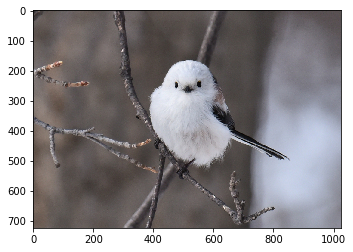

In [80]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_image = Image.open("bird.jpg")
test_image_tensor = (transform((test_image))).unsqueeze(dim=0)

image_size = test_image.size
print("image size: ", image_size)

plt.imshow(test_image)

In [148]:

model = models.vgg16(pretrained=True)


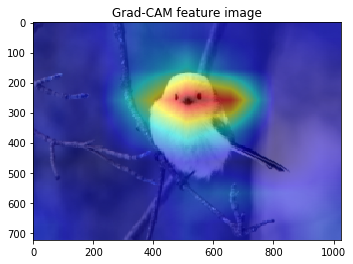

In [149]:
grad_cam = GradCam(model)
feature_image = grad_cam(test_image_tensor).squeeze(dim=0)
feature_image = transforms.ToPILImage()(feature_image)
plt.title("Grad-CAM feature image")
plt.imshow(feature_image.resize(image_size))

# 考察 
全結合の前のConv層が予測したラベルに対してどのくらい影響を与えているのかを勾配でもって計算してる。特徴マップの微小な変化時の分類クラスの確率の変化で特徴マップ内の重要度を決定しているため、入力画像のどの部分がクラス分類に注目されているかが分かる仕組みとなっている。